# Pip Install

In [1]:
!pip install boto3 astropy sfdmap progressbar2

# Initialization

In [5]:
save_model = True
load_model = False
save_dist_mat = True

In [6]:
# imports
import pandas as pd
import numpy as np
import os
import sys
import pickle
import boto3
from matplotlib import pyplot as plt
import time

# random seed
seed = 42
np.random.seed(seed)

# local files paths
local_home_dir_path = os.path.expanduser("~")
local_work_dir_path = os.path.join(local_home_dir_path, 'thesis2')
local_code_dir_path = os.path.join(local_work_dir_path , 'code')

# S3 file paths
endpoint_url = 'https://s3-west.nrp-nautilus.io'
bucket_name = 'tau-astro'
prefix = 'almogh'
s3_work_dir_path = os.path.join(prefix, 'thesis2')
s3_data_dir_path = os.path.join(s3_work_dir_path , 'data')
s3_models_dir_path = os.path.join(s3_work_dir_path , 'models')
s3_final_table_csv_path = os.path.join(s3_data_dir_path, 'SDSS_DR16_all.csv')

s3_client = boto3.client("s3", endpoint_url=endpoint_url)

# adding code folder to path
sys.path.insert(1, local_code_dir_path)
from s3 import to_s3_npy, to_s3_pkl, from_s3_npy, from_s3_pkl, to_s3_fig

2023-01-14 11:19:40.880241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 11:19:41.130228: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-14 11:19:41.862626: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-14 11:19:41.862707: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: 

# Prepare Data

In [7]:
model_name = 'SmallRF'

In [8]:
# prepare model paths
s3_model_dir_path = os.path.join(s3_models_dir_path, model_name)
s3_model_train_dir_path = os.path.join(s3_model_dir_path, 'train')
s3_model_save_path = os.path.join(s3_model_train_dir_path, 'rf.pkl')
# prepare data paths
s3_data_model_dir_path = os.path.join(s3_data_dir_path, model_name)
s3_data_train_dir_path = os.path.join(s3_data_model_dir_path, 'train')
s3_data_test_dir_path = os.path.join(s3_data_model_dir_path, 'test')

In [9]:
# load data
X_train_real = from_s3_npy(s3_client, bucket_name, os.path.join(s3_data_train_dir_path, 'spec.npy'))
X_test_real = from_s3_npy(s3_client, bucket_name, os.path.join(s3_data_test_dir_path, 'spec.npy'))

loading from uri: s3://tau-astro/almogh/thesis2/data/SmallRF/train/spec.npy
loading from uri: s3://tau-astro/almogh/thesis2/data/SmallRF/test/spec.npy


In [25]:
gs_train = from_s3_pkl(s3_client, bucket_name, os.path.join(s3_data_train_dir_path, 'gs.pkl'))

loading from uri: s3://tau-astro/almogh/thesis2/data/SmallRF/train/gs.pkl


In [10]:
# create synthetic data
from uRF_SDSS import return_synthetic_data
X_train_syn = return_synthetic_data(X_train_real, seed)
X_test_syn = return_synthetic_data(X_test_real, seed)

In [11]:
# merge
from uRF_SDSS import merge_work_and_synthetic_samples
Z_train, y_train = merge_work_and_synthetic_samples(X_train_real, X_train_syn)
Z_test, y_test = merge_work_and_synthetic_samples(X_test_real, X_test_syn)

# Train Model

In [12]:
if load_model:
    
    rf = from_s3_pkl(s3_client, bucket_name, s3_model_save_path)
    
else:

    # Set RF hyperparameters
    N_trees = 500
    max_features = 'sqrt'
    min_samples_split = 1000
    max_depth = 10
    max_samples = 1.0
    import sklearn.ensemble
    rf = sklearn.ensemble.RandomForestClassifier(n_estimators=N_trees,
                                                 max_features=max_features,
                                                 max_samples=max_samples,
                                                 min_samples_split=min_samples_split,
                                                 max_depth=max_depth,
                                                 random_state=seed,
                                                 n_jobs=-1,
                                                 verbose=1)
    # Fit RF classifier
    rf.fit(Z_train, y_train)
    
    if save_model:

        to_s3_pkl(rf, s3_client, bucket_name, s3_model_save_path)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished


saving to uri: s3://tau-astro/almogh/thesis2/models/SmallRF/rf.pkl


# Evaluate Model

In [13]:
if not load_model:

    print('Predict on training set')
    y_hat_train = rf.predict(Z_train)

    print('Predict on test set')
    y_hat_test = rf.predict(Z_test)

    print('Evaluating')
    from sklearn.metrics import classification_report
    train_set_report = classification_report(y_train, y_hat_train)
    test_set_report = classification_report(y_test, y_hat_test)
    print('TRAININ-SET:')
    print(train_set_report )
    print('TEST-SET:')
    print(test_set_report)

    if save_model:

        from s3 import log_s3
        log_s3(s3_client, bucket_name, path_in_bucket=s3_model_train_dir_path, log_name='RF_log.txt',
            N_trees = N_trees,
            max_features = max_features,
            max_samples = max_samples,
            min_samples_split = min_samples_split,
            max_depth = max_depth,
            train_set_report = '\n'+train_set_report,
            test_set_report = '\n'+test_set_report
            )

Predict on training set


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s


Predict on test set
Evaluating


[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished


TRAININ-SET:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00     11000
         2.0       1.00      1.00      1.00     11000

    accuracy                           1.00     22000
   macro avg       1.00      1.00      1.00     22000
weighted avg       1.00      1.00      1.00     22000

TEST-SET:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      1100
         2.0       1.00      1.00      1.00      1100

    accuracy                           1.00      2200
   macro avg       1.00      1.00      1.00      2200
weighted avg       1.00      1.00      1.00      2200

saving to uri: s3://tau-astro/almogh/thesis2/models/SmallRF/train/RF_log.txt


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.3s finished


saving to uri: s3://tau-astro/almogh/thesis2/models/SmallRF/train/prob_dist.png


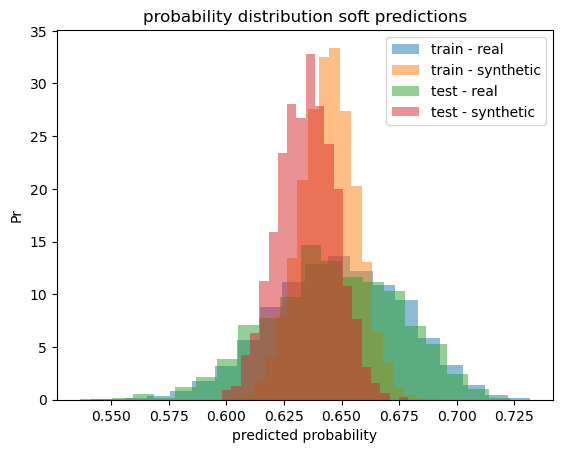

In [14]:
if not load_model:

    p_test = rf.predict_proba(Z_test)
    p_train = rf.predict_proba(Z_train)

    fig = plt.figure()

    plt.hist(p_train[y_train==1,np.where(rf.classes_==1)[0][0]], density=True, bins=20, alpha=0.5, label='train - real')
    plt.hist(p_train[y_train==2,np.where(rf.classes_==2)[0][0]], density=True, bins=20, alpha=0.5, label='train - synthetic')
    plt.hist(p_test[y_test==1,np.where(rf.classes_==1)[0][0]], density=True, bins=20, alpha=0.5, label='test - real')
    plt.hist(p_test[y_test==2,np.where(rf.classes_==2)[0][0]], density=True, bins=20, alpha=0.5, label='test - synthetic')
    plt.legend()
    plt.title("probability distribution soft predictions")
    plt.ylabel("Pr")
    plt.xlabel("predicted probability")

    if save_model:
        to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_model_train_dir_path, 'prob_dist.png'))

In [15]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
mem = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [16]:
if load_model:
    
    dist_mat = from_s3_npy(s3_client, bucket_name, os.path.join(s3_model_train_dir_path, 'dist_mat.npy'))
    
else:

    from uRF_SDSS import calcDisMat
    dist_mat = calcDisMat(rf, X_train_real)

    if save_model:

        to_s3_npy(dist_mat, s3_client, bucket_name, os.path.join(s3_model_train_dir_path, 'dist_mat.npy'))

  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.6s finished


saving to uri: s3://tau-astro/almogh/thesis2/models/SmallRF/train/dist_mat.npy


In [17]:
if load_model:

    weird_scores = from_s3_npy(s3_client, bucket_name, os.path.join(s3_model_train_dir_path, 'weird_scores.npy'))
    
else:
    
    print('Calculating the weirdness scores')
    weird_scores = np.mean(dist_mat, axis=1)

    if save_model:

        to_s3_npy(weird_scores, s3_client, bucket_name, os.path.join(s3_model_train_dir_path, 'weird_scores.npy'))

        if save_dist_mat:
            to_s3_npy(dist_mat, s3_client, bucket_name, os.path.join(s3_model_train_dir_path, 'dist_mat.npy'))

Calculating the weirdness scores
saving to uri: s3://tau-astro/almogh/thesis2/models/SmallRF/train/weird_scores.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/SmallRF/train/dist_mat.npy


In [18]:
if load_model:
    
    sne = from_s3_npy(s3_client, bucket_name, os.path.join(s3_model_train_dir_path, 'tsne.npy'))
    
else:

    print('Running T-SNE')
    from sklearn.manifold import TSNE
    sne = TSNE(n_components=2, perplexity=25, metric='precomputed', verbose=1, random_state=seed).fit_transform(dist_mat)

    if save_model:

        print('Saving T-SNE')
        to_s3_npy(sne, s3_client, bucket_name, os.path.join(s3_model_train_dir_path, 'tsne.npy'))

Running T-SNE


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 11000 samples in 0.197s...
[t-SNE] Computed neighbors for 11000 samples in 1.539s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11000
[t-SNE] Computed conditional probabilities for sample 2000 / 11000
[t-SNE] Computed conditional probabilities for sample 3000 / 11000
[t-SNE] Computed conditional probabilities for sample 4000 / 11000
[t-SNE] Computed conditional probabilities for sample 5000 / 11000
[t-SNE] Computed conditional probabilities for sample 6000 / 11000
[t-SNE] Computed conditional probabilities for sample 7000 / 11000
[t-SNE] Computed conditional probabilities for sample 8000 / 11000
[t-SNE] Computed conditional probabilities for sample 9000 / 11000
[t-SNE] Computed conditional probabilities for sample 10000 / 11000
[t-SNE] Computed conditional probabilities for sample 11000 / 11000
[t-SNE] Mean sigma: 0.016178
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.386139
[t-SNE] KL 

saving to uri: s3://tau-astro/almogh/thesis2/models/SmallRF/train/weirdness_scores_histogram.png


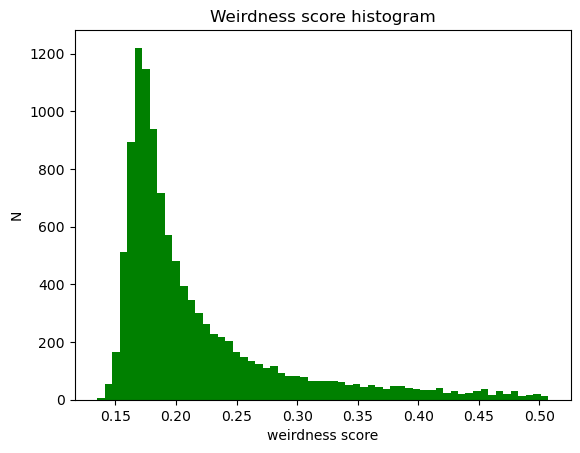

In [19]:
if not load_model:
    
    fig = plt.figure()
    tmp = plt.hist(weird_scores, bins=60, color="g")
    plt.title("Weirdness score histogram")
    plt.ylabel("N")
    plt.xlabel("weirdness score")

    if save_model:
        to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_model_train_dir_path, 'weirdness_scores_histogram.png'))

saving to uri: s3://tau-astro/almogh/thesis2/models/SmallRF/train/distances_histogram.png


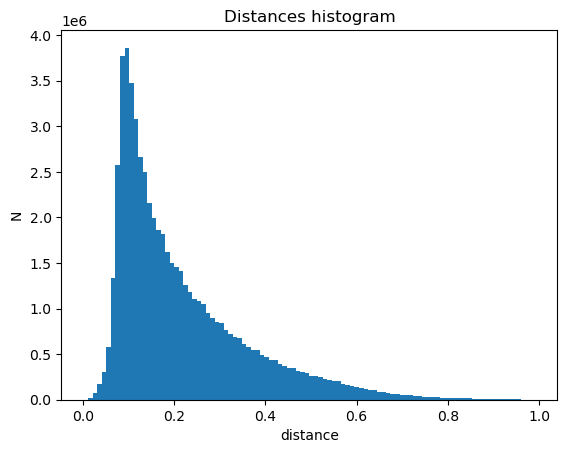

In [20]:
if not load_model:

    distances = dist_mat[np.tril_indices(dist_mat.shape[0], -1)]

    fig = plt.figure()
    tmp = plt.hist(distances, bins=100)
    plt.title("Distances histogram")
    plt.ylabel("N")
    plt.xlabel("distance")

    if save_model:
        to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_model_train_dir_path, 'distances_histogram.png'))

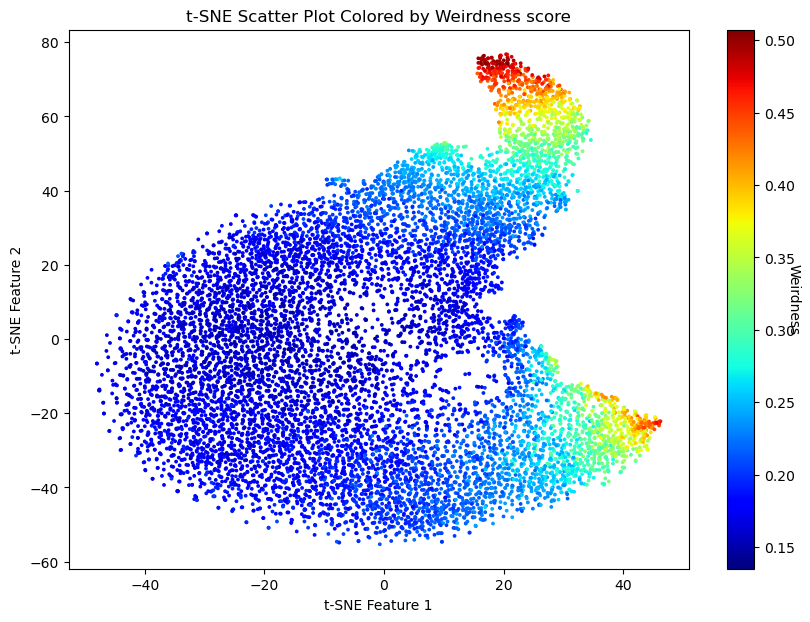

saving to uri: s3://tau-astro/almogh/thesis2/models/SmallRF/train/tsne_colored_by_weirdness.png


In [23]:
if not load_model:
    
    sne_f1 = sne[:, 0]
    sne_f2 = sne[:, 1]

    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    im_scat = ax.scatter(sne_f1, sne_f2, s=3, c=weird_scores, cmap=plt.cm.get_cmap('jet'), picker=1)
    ax.set_xlabel('t-SNE Feature 1')
    ax.set_ylabel('t-SNE Feature 2')
    ax.set_title(r't-SNE Scatter Plot Colored by Weirdness score')
    clb = fig.colorbar(im_scat, ax=ax)
    clb.ax.set_ylabel('Weirdness', rotation=270)
    plt.show()

    if save_model:
        to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_model_train_dir_path, 'tsne_colored_by_weirdness.png'))

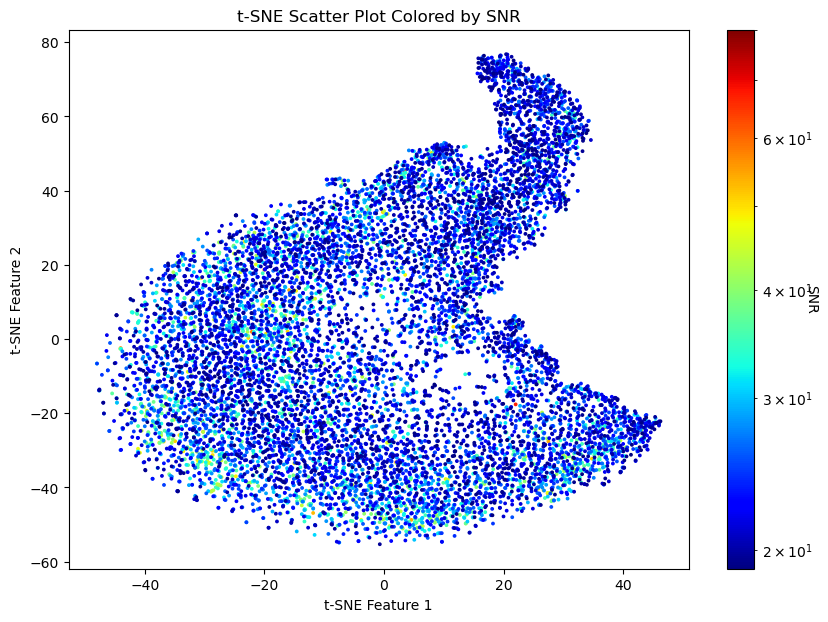

saving to uri: s3://tau-astro/almogh/thesis2/models/SmallRF/train/tsne_colored_by_snr.png


In [27]:
if not load_model:
    
    snr = gs_train.snMedian
    
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    import matplotlib.colors as colors
    im_scat = ax.scatter(sne_f1, sne_f2, s=3, c=snr, cmap=plt.cm.get_cmap('jet'), norm=colors.LogNorm(vmin=snr.min(), vmax=80))
    ax.set_xlabel('t-SNE Feature 1')
    ax.set_ylabel('t-SNE Feature 2')
    ax.set_title(r't-SNE Scatter Plot Colored by SNR')
    clb = fig.colorbar(im_scat, ax=ax)
    clb.ax.set_ylabel('SNR', rotation=270)
    plt.show()

if save_model:
    to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_model_train_dir_path, 'tsne_colored_by_snr.png'))